## First over bowling signals
### How well do bowlers bounce back?

The era of homogenised T20 franchise leagues has given rise to equally homogenised cricket commentary. With very similar players playing for characterless teams week in, week out at some parts of the season, commentators are often content to settle back into cricketing cliché. Amongst this litany of clichés is the idea of ‘setting the tone early’ or ‘settling into a spell’ as a bowler, and I am eager to investigate whether this is true. It is a fairly logical supposition, I can certainly recall several instances where things have unravelled for bowlers after a poor start. But eager to rigorously test this, I will attempt to create a model to predict how a bowler will perform in the rest of their 4-over spell, based on their first over. Are there foreboding signals like bowling lots of wides or no balls in the first over? Perhaps poor later game performance is related to how many boundaries or runs are scored in that first over? Maybe taking wickets in contrast is a positive signal for the bowler's future performance in that game?

We will again use our sample of 2024 data (full details in README.md and in bowling_effectiveness_by_phase.ipynb), and we load it and some packages now.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/four_over_spells.csv', low_memory=False)
print(df.head())

   match_id bowler_id bowl_type   sex  over_1_phase  runs_total_1  wickets_1  \
0   1375850  4d7f517e      Spin  male     Powerplay             7          0   
1   1375850  b0946605      Seam  male     Powerplay            11          0   
2   1375850  bbd41817      Seam  male     Powerplay            12          0   
3   1375850  c5aef772      Seam  male  Middle Overs             8          0   
4   1375850  03806cf8      Seam  male     Powerplay             7          0   

   extra_ball_count_1  runs_other3  wickets_other3 venue_id  
0                   0           35               0   4aus82  
1                   0           36               2   4aus82  
2                   0           30               3   4aus82  
3                   1           31               1   4aus82  
4                   0           37               0   4aus82  


The data contains the following variables which will be used in modelling:

#### Variables:
$\text{match\_id}$ - the match identifier

$\text{bowler\_id}$ - the bowler identifier

$\text{bowl\_type}$ - the broad categorical bowling type for the bowler, either 'Seam' or 'Spin'.

$\text{sex}$ - the bowler's sex, either 'male' or 'female'.

$\text{over\_1\_phase}$ - the phase that the bowler's first over is delivered in, either 'Powerplay' or 'Middle Overs'.

$\text{runs\_total\_1}$ - the number of runs conceded by the bowler in their first over.

$\text{wickets\_1}$ - the number of wickets taken by the bowler in their first over.

$\text{extra\_ball\_count\_1}$ - the number of extra balls bowled by the bowler in their first over, as a result of a wide or no ball being bowled.

$\text{runs\_other3}$ - the number of runs scored in the other 3 overs of the bowler's 4-over spell.

$\text{wickets\_other3}$ - the number of wickets taken in the other 3 overs of the bowler's 4-over spell.

$\text{venue\_id}$ - the venue identifier.

runs_other3 and wickets_other3 are the two chosen measures of the quality of a bowler's performance in the rest of their spell, and will be our response variables. We will create a model for each. As the data contains multiple spells by the same bowler and multiple spells bowled in the same stadium, we do not have independent observations and so standard OLS regression would not be appropriate here. Since our goal is to identify generalisable performance signals rather than to predict specific match outcomes at specific venues, we adopted a Generalised Estimating Equations (GEE) framework. This allows us to estimate the population-averaged effects of the first over on the rest of the spell for both runs and wickets, while accounting for the correlation of performances within venues and by players. After my exploratory data analysis revealed no clear non-linear relationships, we will now produce plots to visually examine the distributions of the two response variables and confirm the type of GEEs we will use. We start with the runs conceded in the other three overs.

Mean of runs_other3: 22.52
Variance of runs_other3: 72.18


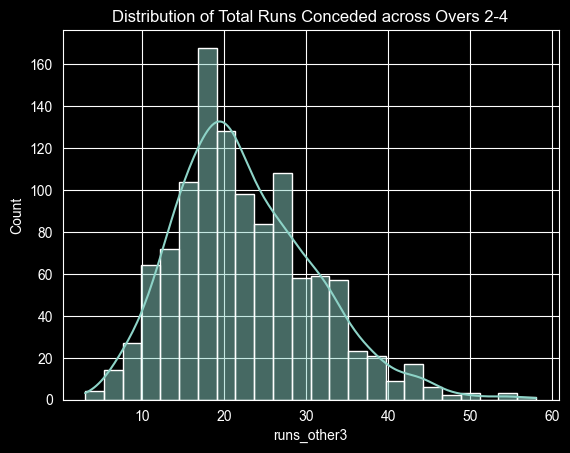

In [2]:
mean_runs = df['runs_other3'].mean()
variance_runs = df['runs_other3'].var()

print(f"Mean of runs_other3: {mean_runs:.2f}")
print(f"Variance of runs_other3: {variance_runs:.2f}")

sns.histplot(df['runs_other3'], kde=True)
plt.title('Distribution of Total Runs Conceded across Overs 2-4')
plt.show()

The histogram for runs is right-skewed, with the distribution peaking between 15 and 20 runs but having a long tail extending toward much higher run totals. The shape and large difference in mean and variance suggests that runs_other3 behaves like a normal random variable so we will use the Gaussian GEE.

Mean of wickets_other3: 1.25
Variance of wickets_other3: 1.07


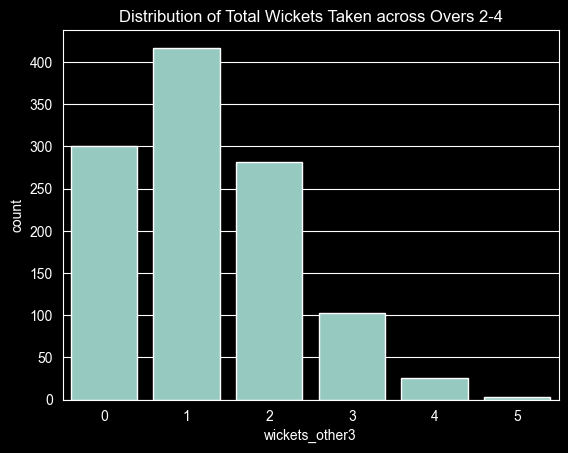

In [3]:
mean_wickets = df['wickets_other3'].mean()
variance_wickets = df['wickets_other3'].var()

print(f"Mean of wickets_other3: {mean_wickets:.2f}")
print(f"Variance of wickets_other3: {variance_wickets:.2f}")

sns.countplot(x=df['wickets_other3'])
plt.title('Distribution of Total Wickets Taken across Overs 2-4')
plt.show()

The count plot clearly shows the discrete count data, where one wicket is the most common outcome, and the mean (1.25) is approximately equal to the variance (1.07). This plot demonstrates that the Poisson GEE is likely to be the best model.

The two models are designed to try to isolate the predictive effect of the first over's events on subsequent match performance, while ensuring that we control for possibly confounding factors.  The primary predictors of interest are runs_total_1 (negative bowling outcome), wickets_1 (positive bowling outcome), and extra_ball_count_1 (a measure of process indiscipline). We include bowl_type as an interaction term to try to ascertain if the impact of a good or bad start differs systematically between pace and spin bowlers. We include over_1_phase and sex as fixed-effect controls, as the match context of the first over (e.g. powerplay vs. middle overs) and the baseline scoring rates in men's vs. women's cricket will affect the relative performance.

To handle the non-independence of data (multiple matches played at the same stadium), we employ a Generalised Estimating Equations (GEE) framework clustered by venue_id. Unlike a Mixed-Effects model which estimates specific random intercepts for every venue or bowler, the GEE focuses on the 'population-averaged' effects — telling us how the average bowler's outcome changes given a specific start, while robustly adjusting standard errors for the correlation of scores within specific venues.

It is likely that there will be multicollinearity present between our primary predictors: runs_total_1, wickets_1 and extra_balls_1 (e.g. more runs conceded, less wickets taken). High multicollinearity makes it difficult for the model to isolate the effect of individual predictors, leading to inflated standard errors and coefficient estimates that are highly sensitive to small changes in the data. Therefore, we will investigate this next and try to address any potential issues now before fitting the models.

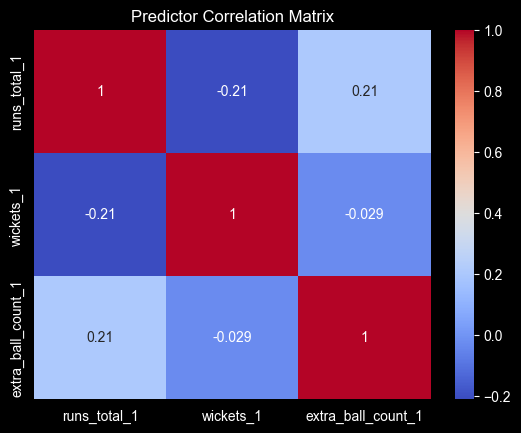

In [4]:
predictor_cols = ['runs_total_1', 'wickets_1', 'extra_ball_count_1']
corr_matrix = df[predictor_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Predictor Correlation Matrix')
plt.show()

The correlation matrix reveals no issues with multicollinearity, as all absolute correlation values are quite low ($|r| \leq 0.21$). Despite the initial expectation of a relationship between runs and wickets in the first over, these predictors appear sufficiently independent to be included together in both models without destabilising the coefficient estimates.

Ordinarily, I do most of my statistical modelling in R. However, to better integrate it with my GitHub repository and the binder system, we will do it in python using the 'statsmodels' package (It is less streamlined than R for this, but it gets the job done). We will start with fitting the Poisson GEE for runs conceded in the other three overs, and checking its dispersion parameter. We use an Exchangeable correlation structure for the GEE models. This structure assumes that the correlation between any pair of bowling spells within the same venue is constant, regardless of when those matches occurred. This seems the most appropriate choice for venue-clustered data, as there is no inherent logical ordering to matches played at a single ground. An unstructured covariance matrix, while flexible, would require estimating far too many parameters for the number of venues in our dataset, likely leading to convergence issues.

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

fixed_formula_runs = """
runs_other3 ~ (runs_total_1 + wickets_1 + extra_ball_count_1) * bowl_type + over_1_phase + sex
"""

model_runs_gee = smf.gee(
    formula=fixed_formula_runs,
    data=df,
    groups=df['venue_id'],
    family=sm.families.Gaussian(),
    cov_struct=sm.cov_struct.Exchangeable()
)

results_runs_gee = model_runs_gee.fit()
print(results_runs_gee.summary())

                               GEE Regression Results                              
Dep. Variable:                 runs_other3   No. Observations:                 1130
Model:                                 GEE   No. clusters:                       63
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  68
Family:                           Gaussian   Mean cluster size:                17.9
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Wed, 17 Dec 2025   Scale:                          66.442
Covariance type:                    robust   Time:                         20:52:38
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                         

The Gaussian GEE results indicate that the events of the first over have little predictive power over the runs conceded in the remainder of the spell. The coefficient for runs_total_1 is effectively zero (and likely statistically insignificant), suggesting that a high-scoring first over does not "set the tone" for a poor spell; rather, bowlers tend to revert to the mean. There is a significant negative effect of wickets_1 on runs_other3, but this could be because better bowlers take more wickets and concede fewer runs in general. However, it is possible that more wickets reduce future runs conceded by the bowler because it reduces runs conceded overall. Wickets are a finite resource in cricket, and in T20s the quality of the batting often reduces further down the batting order. For every additional first over wicket, the estimated number of runs conceded in a bowler's other 3 overs decreases by approximately 1.46 runs, assuming the bowling type is pace. The interaction effect between wickets in the first over and bowling type is not significant. There is no significant effect of extra_ball_count_1 on runs_other3, suggesting that wayward early bowling isn't a good predictor of a bowler's overall run prevention power.

Interestingly, while the controls for sex and bowling type are significant, the effect of over_1_phase is not statistically significant. This suggests that the effect of the first over on subsequent performance is not dependent on the match context of the first over.

To validate the model's assumptions, we will examine the residuals. Since we used a Gaussian family, the residuals should be approximately normally distributed. We can check this visually using a Q-Q plot.

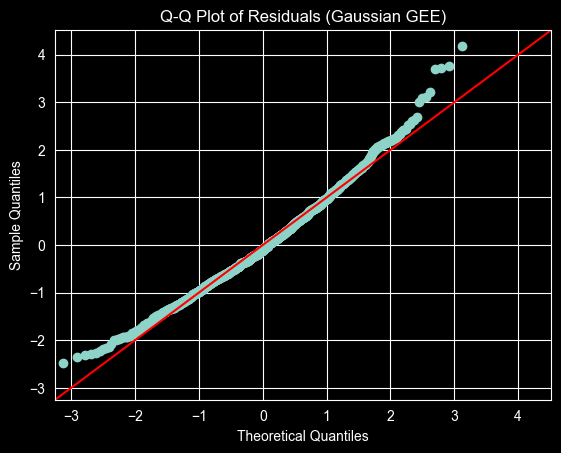

In [6]:
fig = sm.qqplot(results_runs_gee.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Gaussian GEE)")
plt.show()

As the points lie roughly along the red 45-degree line, the assumption of normality is fairly well satisfied. The minor deviations in the tails suggest that a different distribution family (like a Poisson or Negative Binomial if we assume that runs are strictly count data) might capture the tails slightly better. However, as runs are theoretically continuous and heavy tails are common in sports data, this fit is acceptable (particularly as GEEs are very robust).

We will now fit the Poisson GEE for wickets in the other three overs.

In [7]:
fixed_formula_wickets = """
wickets_other3 ~ (runs_total_1 + wickets_1 + extra_ball_count_1) * bowl_type + over_1_phase + sex
"""

model_wickets_gee = smf.gee(
    formula=fixed_formula_wickets,
    data=df,
    groups=df['venue_id'],
    family=sm.families.Poisson(),
    cov_struct=sm.cov_struct.Exchangeable()
)

results_wickets_gee = model_wickets_gee.fit()
print(results_wickets_gee.summary())

pearson_chi2 = results_wickets_gee.pearson_chi2
df_resid = results_wickets_gee.df_resid
print(f"phi = {pearson_chi2 / df_resid}")

                               GEE Regression Results                              
Dep. Variable:              wickets_other3   No. Observations:                 1130
Model:                                 GEE   No. clusters:                       63
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  68
Family:                            Poisson   Mean cluster size:                17.9
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Wed, 17 Dec 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         20:52:38
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                         

We have mild underdispersion in the wicket data ($\phi \approx 0.86$). This indicates that wicket-taking in the remaining overs is slightly more consistent than a standard Poisson process implies. The robust standard errors provided by the GEE account for this, ensuring valid inference without requiring model alteration.

Each first over wicket is associated with a statistically significant 13.8% reduction in wickets across the other 3 overs for seam bowlers. This is likely driven by regression to the mean. If a bowler takes a wicket in the first over (a fairly rare event), they are statistically likely to perform closer to the average in subsequent overs. With a maximum of 10 wickets to be taken (often less) in a 20-over innings, zero wicket overs are the most common outcome. There is statistically significant evidence of a smaller reduction in future wickets for spin bowlers when they take first over wickets. But this may be due to the spin-friendly conditions of both the men's and women's 2024 T20 World Cups that make up many of the matches in our sample (hosted jointly by the USA & West Indies and by the UAE respectively).

Similarly to the Gaussian model, wayward bowling (through extra_ball_count_1) and runs conceded in the first over have no significant effect on the number of wickets taken by a bowler in their remaining three overs. In this model, however, the difference in the effects does not change by sex. Moreover, in this model the opposite control variables are significant, the phase of play is significant but sex and bowler type are not.

While the coefficients provide a rigorous estimate of these effects, they can be somewhat abstract to interpret in isolation. To better visualise the practical difference between a 'bad' start and a 'good' start, we will predict the expected runs and wickets for a bowler in two distinct, hypothetical scenarios. We will use a hypothetical male seam bowler, whose first over was bowled in the powerplay. A 'nightmare' start will be fifteen runs conceded, zero wickets taken, and one extra ball bowled. We contrast that with an 'ideal' start: seven runs conceded, one wicket taken, and no extra balls required.

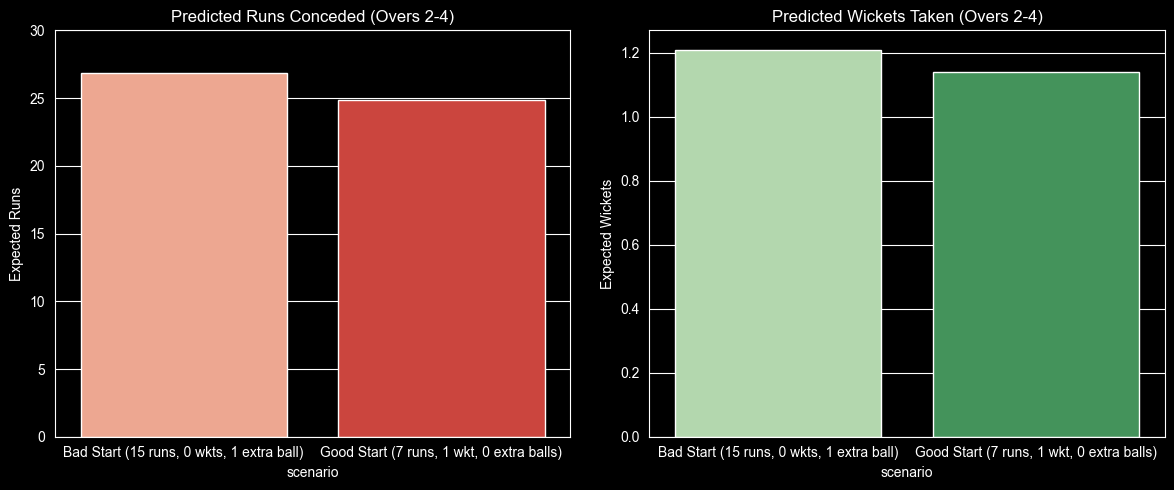

In [8]:
# Dummy dataset for prediction
pred_data = pd.DataFrame({
    'scenario': ['Bad Start (15 runs, 0 wkts, 1 extra ball)', 'Good Start (7 runs, 1 wkt, 0 extra balls)'],
    'runs_total_1': [15, 7],
    'wickets_1': [0, 1],
    'extra_ball_count_1': [1, 0],
    'bowl_type': ['Seam', 'Seam'],
    'over_1_phase': ['Powerplay', 'Powerplay'],
    'sex': ['male', 'male'],
    'venue_id': [df['venue_id'].mode()[0], df['venue_id'].mode()[0]] # Dummy venue
})

pred_data['sex'] = pred_data['sex'].astype('object')
pred_data['bowl_type'] = pred_data['bowl_type'].astype('object')

# Predict using both models
pred_runs = results_runs_gee.predict(pred_data)
pred_wickets = results_wickets_gee.predict(pred_data)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Runs Plot
sns.barplot(x=pred_data['scenario'], y=pred_runs, ax=ax[0], palette="Reds", hue=pred_data['scenario'], legend=False)
ax[0].set_title("Predicted Runs Conceded (Overs 2-4)")
ax[0].set_ylabel("Expected Runs")
ax[0].set_ylim(0, 30)

# Wickets Plot
sns.barplot(x=pred_data['scenario'], y=pred_wickets, ax=ax[1], palette="Greens", hue=pred_data['scenario'], legend=False)
ax[1].set_title("Predicted Wickets Taken (Overs 2-4)")
ax[1].set_ylabel("Expected Wickets")

plt.tight_layout()
plt.show()

This plot reaffirms that a 'bad' start may snowball in terms of runs conceded, but a 'good' one does not guarantee future wickets.

Returning to the clichés introduced at the start, our investigation suggests that 'setting the tone' with a strong first over largely has no effect on the bowler's other three. A bowler's run prevention in the first over — whether the batters take them for runs or they struggle with wides — has statistically zero impact on their ability to restrict runs or take wickets in the remainder of their spell. Taking wickets in the first over is associated with better run prevention in the other three overs. However, this may not be an individual effect, as one bowler taking early wickets may be associated with others doing the same, leading to more favourable future bowling conditions (lower order batters aren't as good).

While taking a first over wicket is valuable for the immediate impact on the game state, it is not a harbinger of more wickets for the bowler; in fact, our model suggests a reversion to the mean. Ultimately, T20 bowling spells appear to be a series of independent events rather than a narrative arc.

*Key limitations*: By only including four-over spells, we introduce a degree of survivor bias, as we lose the most disastrous first overs where bowlers are immediately removed from the attack. However, modern T20 captains often stick to pre-planned bowling strategies for their premier bowlers; therefore, our sample likely still captures a wide range of 'poor starts' that were tactically deemed recoverable, rather than just the perfect ones. We also miss spells where a bowler started well but was removed after a poor second or third over. Additionally, as our sample is focused on full-member nations only, these results should not be generalised to either domestic or associate cricket. This is because there are likely more inexperienced bowlers who may not be as adept at dealing with the pressure or bouncing back from poor starts. Furthermore, teams in associate or lower level domestic cricket may have less bowling depth in their team, forcing them to persist with bowlers starting poorly more often, possibly changing our results.

#### Model 1 - Gaussian Generalised Estimating Equation model:

Response Variable: $\text{runs\_other3}$

Marginal Mean:
$$E[\text{runs\_other3}_{ij}] = \mu_{ij} = \mathbf{\beta}^T \mathbf{x}_{ij}$$
Variance Structure:
$$Var(\text{runs\_other3}_{ij}) = \phi$$
(Where $\phi$ is the scale parameter, constant for Gaussian)
Correlation Structure:
$$Corr(\text{runs\_other3}_{ij}, \text{runs\_other3}_{ik}) = \rho$$
(Exchangeable correlation $\rho$ for any two spells $j, k$ at the same venue $i$)

#### Model 2 - Poisson Generalised Estimating Equation model:

Response Variable: $\text{wickets\_other3}$ (Count Data)

Marginal Mean (Log Link):
$$\log(E[\text{wickets\_other3}_{ij}]) = \log(\mu_{ij}) = \mathbf{\beta}^T \mathbf{x}_{ij}$$
Variance Structure:
$$Var(\text{wickets\_other3}_{ij}) = \phi \cdot \mu_{ij}$$
(Where $\phi \approx 0.86$ accounts for the observed underdispersion)



$\mathbf{\beta}^T \mathbf{x}_{ij}$ in both models is the fixed effects component. It is calculated as the dot product of the coefficient vector $\mathbf{\beta}$ (transposed) and the covariate vector $\mathbf{x}_{ij}$. This includes the intercept, primary predictors ($\text{runs\_total\_1}$, $\text{wickets\_1}$, $\text{extra\_balls\_count\_1}$), control variables ($\text{over\_1\_phase}$, $\text{sex}$), and three interaction terms between the primary predictors and the $\text{bowl\_type}$ variable.

###### Research
Learned about the GEE from sources including this YouTube video: https://www.youtube.com/watch?v=diXAmukwY2w